In [4]:
#Aman Penmetcha
#Written for AVATRINA,  Feb 2022
#Code to generate 360 Birds eye of TRINA surrounding using 4 usb cameras

from re import sub
from turtle import back, right
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import io
import imutils
cv2.ocl.setUseOpenCL(False)

In [13]:
#where is each camera
frontIndex = 3
leftIndex = 0
backIndex = 1
rightIndex = 2
spareCam = 1

##########
#this function takes the file name as a string eg: rightCamDesired.png and which camera: 1, 3, 5, or 7 and
#stores a image to later calculate homography with

def takePicture(fileName, camNumber):
    cap = cv2.VideoCapture(camNumber) #choose which camera
    while(True):
        ret, frame = cap.read() # return a single frame in variable `frame`
        cv2.imshow('Take Picture for: ' + fileName + '||| y for take picture q for dont take picture', frame) #display the captured image
        if cv2.waitKey(1) & 0xFF == ord('y'): #save on pressing 'y' 
            cv2.imwrite(fileName, frame)
            cv2.destroyAllWindows()
            break
        elif cv2.waitKey(1) == ord('q'): #dont save the picture on pressing 'q'
            print('No picture taken')
            cv2.destroyAllWindows()
            break

    cap.release()


def calibrate():
    #taking pics for the gram 
    
    # takePicture('frontCamActual.png', frontIndex)
    # takePicture('frontCamDesired.png', spareCam) 
    # takePicture('rightCamActual.png', rightIndex)  
    # takePicture('rightCamDesired.png',  spareCam) 
    # takePicture('leftCamActual.png', leftIndex)
    # takePicture('leftCamDesired.png', spareCam)
    # takePicture('backCamActual.png', backIndex)
    # takePicture('backCamDesired.png', spareCam)
    

    takePicture('frontStitchingImage.png', frontIndex)
    takePicture('leftStitchingImage.png', leftIndex)
    takePicture('backStitchingImage.png', backIndex)
    takePicture('rightStitchingImage.png', rightIndex)

#functions for stitching below
def detectAndDescribe(image, method=None):
    """
    Compute key points and feature descriptors using an specific method
    """
    
    assert method is not None, "You need to define a feature detection method. Values are: 'sift', 'surf'"
    
    # detect and extract features from the image
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'brisk':
        descriptor = cv2.BRISK_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create(nfeatures = 200000)
        
    # get keypoints and descriptors
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

def get_img_from_fig(fig, dpi=180):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=dpi)
    buf.seek(0)
    img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    buf.close()
    img = cv2.imdecode(img_arr, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

#comment out calibrate line below if you want to skip calibration 
#if not commented you can still skip taking pictures but you will have to press q 8 times
# calibrate()

#images paths to calculate top down homography from
pathFrontCamActual = r'C:\Users\Aman\Desktop\School\Python\TRINA\frontCamActual.png'
pathFrontCamDesired = r'C:\Users\Aman\Desktop\School\Python\TRINA\frontCamDesired.png'
pathRightCamActual = r'C:\Users\Aman\Desktop\School\Python\TRINA\rightCamActual.png'
pathRightCamDesired = r'C:\Users\Aman\Desktop\School\Python\TRINA\rightCamDesired.png'
pathLeftCamActual = r'C:\Users\Aman\Desktop\School\Python\TRINA\leftCamActual.png'
pathLeftCamDesired = r'C:\Users\Aman\Desktop\School\Python\TRINA\leftCamDesired.png'
pathBackCamActual = r'C:\Users\Aman\Desktop\School\Python\TRINA\backCamActual.png'
pathBackCamDesired = r'C:\Users\Aman\Desktop\School\Python\TRINA\backCamDesired.png'


frontActual = cv2.imread(pathFrontCamActual)
frontDesired = cv2.imread(pathFrontCamDesired)
rightActual = cv2.imread(pathRightCamActual)
rightDesired = cv2.imread(pathRightCamDesired)
leftActual = cv2.imread(pathLeftCamActual)
leftDesired = cv2.imread(pathLeftCamDesired)
backActual = cv2.imread(pathBackCamActual)
backDesired = cv2.imread(pathBackCamDesired)

imgs = [frontActual,frontDesired,rightActual,rightDesired,leftActual,leftDesired,backActual,backDesired]
t = time.time()

#patternSize stores the size of the chessboard you are looking for
patternSize = (8,6)

In [14]:
retFA, cornersFrontActual = cv2.findChessboardCorners(frontActual, patternSize)
retFD, cornersFrontDesired = cv2.findChessboardCorners(frontDesired, patternSize)
retRA, cornersRightActual = cv2.findChessboardCorners(rightActual, patternSize)
retRD, cornersRightDesired = cv2.findChessboardCorners(rightDesired, patternSize)
retLA, cornersLeftActual = cv2.findChessboardCorners(leftActual, patternSize)
retLD, cornersLeftDesired = cv2.findChessboardCorners(leftDesired, patternSize)
retBA, cornersBackActual = cv2.findChessboardCorners(backActual, patternSize)
retBD, cornersBackDesired = cv2.findChessboardCorners(backDesired, patternSize)

Hfront, _1 = cv2.findHomography(cornersFrontActual, cornersFrontDesired)
Hright, _2 = cv2.findHomography(cornersRightActual, cornersRightDesired)
Hleft, _3 = cv2.findHomography(cornersLeftActual, cornersLeftDesired)
Hback, _4 = cv2.findHomography(cornersBackActual, cornersBackDesired)
print("Top Down Matricies Computed")
# imgTemp1 = cv2.warpPerspective(cv2.imread(r'C:\Users\Aman\Desktop\School\Python\frontStitchingImage.png'), Hfront, (frontActual.shape[1], frontActual.shape[0]))
# cv2.imwrite('frontStitchingImageWarped.png', imgTemp1)
# imgTemp2 = cv2.warpPerspective(cv2.imread(r'C:\Users\Aman\Desktop\School\Python\leftStitchingImage.png'), Hleft, (frontActual.shape[1], frontActual.shape[0]))
# cv2.imwrite('leftStitchingImageWarped.png', imgTemp2)
# print("Done")
# cv2.imshow('Front Cam Warped', frontCam_warp)
# cv2.imshow('Right Cam Warped', rightCam_warp)
# cv2.imshow('Left Cam Warped', leftCam_warp)

#stitching starts here
feature_extractor = 'orb' # one of 'sift', 'surf', 'brisk', 'orb'
feature_matching = 'bf'

#images to calculate stitching matricies from
frontStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\School\Python\TRINA\frontStitchingImage.png')
leftStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\School\Python\TRINA\leftStitchingImage.png')
backStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\School\Python\TRINA\backStitchingImage.png')
rightStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\School\Python\TRINA\rightStitchingImage.png')

Top Down Matricies Computed


In [15]:
help(cv2.findHomography)

Help on built-in function findHomography:

findHomography(...)
    findHomography(srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]]) -> retval, mask
    .   @brief Finds a perspective transformation between two planes.
    .   
    .   @param srcPoints Coordinates of the points in the original plane, a matrix of the type CV_32FC2
    .   or vector\<Point2f\> .
    .   @param dstPoints Coordinates of the points in the target plane, a matrix of the type CV_32FC2 or
    .   a vector\<Point2f\> .
    .   @param method Method used to compute a homography matrix. The following methods are possible:
    .   -   **0** - a regular method using all the points, i.e., the least squares method
    .   -   @ref RANSAC - RANSAC-based robust method
    .   -   @ref LMEDS - Least-Median robust method
    .   -   @ref RHO - PROSAC-based robust method
    .   @param ransacReprojThreshold Maximum allowed reprojection error to treat a point pair as an inlier
    .   

In [16]:
#test images
# frontStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\TRINA\OPENCV\front360Test.png')
# leftStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\TRINA\OPENCV\left360Test.png')
# backStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\TRINA\OPENCV\back360Test.png')
# rightStitchImage = cv2.imread(r'C:\Users\Aman\Desktop\TRINA\OPENCV\right360Test.png')

# frontCam_warp_gray = cv2.cvtColor(frontCam_warp, cv2.COLOR_RGB2GRAY)
# leftCam_warp_gray = cv2.cvtColor(leftCam_warp, cv2.COLOR_RGB2GRAY)
# backCam_warp_gray = cv2.cvtColor(backCam_warp, cv2.COLOR_RGB2GRAY)
# rightCam_warp_gray = cv2.cvtColor(rightCam_warp, cv2.COLOR_RGB2GRAY)

#pass in the grayscale of images that need to be stitched (these will be the top down warped images)
#needs both grayscale and normal to compute the stitching matrix properly
def calculateStitchingMatrix(img1, img1Gray, img2, img2Gray):
    kpsA, featuresA = detectAndDescribe(img1Gray, method=feature_extractor)
    kpsB, featuresB = detectAndDescribe(img2Gray, method=feature_extractor)
    

    # display the keypoints and features detected on both images
    # fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
    # ax1.imshow(cv2.drawKeypoints(img1,kpsA,None,color=(0,255,0)))
    # ax1.set_xlabel("(a)", fontsize=14)
    # ax2.imshow(cv2.drawKeypoints(img2,kpsB,None,color=(0,255,0)))
    # ax2.set_xlabel("(b)", fontsize=14)
    # plt.show()

    if feature_matching == 'bf':
        matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
        img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,matches[:100],
                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    elif feature_matching == 'knn':
        matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
        img3 = cv2.drawMatches(img1,kpsA,img2,kpsB,np.random.choice(matches,100),
                            None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    plt.imshow(img3)
    plt.show()

    M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
    if M is None:
        print("Error! Stitching Homography Matrix couldnt be calculated for kpsA and kpsB")
    (matches, Hstitch, status) = M
    return Hstitch

def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[0,0],[0,h1],[w1,h1],[w1,0]]).reshape(-1,1,2)
    pts2 = np.float32([[0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate

    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result[t[1]:h1+t[1],t[0]:w1+t[0]] = img1
    return result

def warpSingleImage(img,H):
    h,w = img.shape[:2]
    print(h,w)
    pts = np.float32([[0,0],[0,h],[w,h],[w,0]]).reshape(-1,1,2)
    pts = cv2.perspectiveTransform(pts,H)
    print(pts)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
#     template = np.zeros((xmax-xmin,ymax-ymin,3))
    t = [-xmin,-ymin]
    print(t,xmax,ymax)
    Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result = cv2.warpPerspective(img, Ht.dot(H), (xmax-xmin, ymax-ymin))
    result = cv2.resize(result,(480,720))
#     template[t[1]:h+t[1],t[0]:w+t[0]] = result
    return result

In [17]:
#applies top down homography Uncomment next block of 4 lines if you want this to run
# frontStitchImage_warp = warpSingleImage(frontStitchImage, Hfront)
# leftStitchImage_warp = warpSingleImage(leftStitchImage, Hleft)
# backStitchImage_warp = warpSingleImage(backStitchImage, Hback)
# rightStitchImage_warp = warpSingleImage(rightStitchImage, Hright)

In [18]:
# stitchImages = [frontStitchImage_warp,leftStitchImage_warp,backStitchImage_warp,rightStitchImage_warp]

# for img in stitchImages:
#     plt.imshow(img)
#     plt.show()

Raw matches (Brute force): 1241


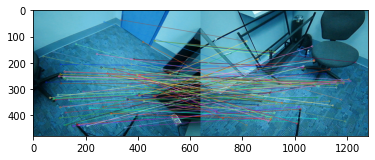

Raw matches (Brute force): 961


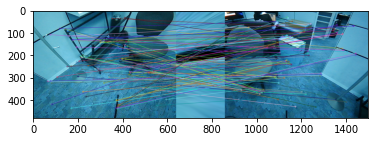

Raw matches (Brute force): 806


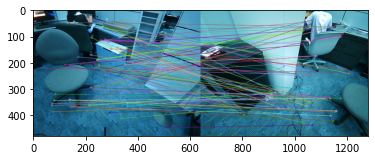

DONE COMPUTING


In [19]:
# cv2.imshow('', frontStitchImage_warp)
# cv2.waitKey(10)

#skips top down homography for debugging
frontStitchImage_warp = frontStitchImage
leftStitchImage_warp = leftStitchImage
backStitchImage_warp = backStitchImage
rightStitchImage_warp = rightStitchImage


frontStitchImage_warp_gray = cv2.cvtColor(frontStitchImage_warp, cv2.COLOR_RGB2GRAY)
leftStitchImage_warp_gray = cv2.cvtColor(leftStitchImage_warp, cv2.COLOR_RGB2GRAY)
backStitchImage_warp_gray = cv2.cvtColor(backStitchImage_warp, cv2.COLOR_RGB2GRAY)
rightStitchImage_warp_gray = cv2.cvtColor(rightStitchImage_warp, cv2.COLOR_RGB2GRAY)

HFL = calculateStitchingMatrix(frontStitchImage_warp, frontStitchImage_warp_gray, leftStitchImage_warp, leftStitchImage_warp_gray)
subStitchFL = warpTwoImages(leftStitchImage_warp, frontStitchImage_warp, HFL)

subStitchFL_gray = cv2.cvtColor(subStitchFL, cv2.COLOR_RGB2GRAY)
HFLB = calculateStitchingMatrix(subStitchFL, subStitchFL_gray, backStitchImage_warp, backStitchImage_warp_gray)

subStitchFLB = warpTwoImages(backStitchImage_warp, subStitchFL, HFLB)

subStitchFLB_gray = cv2.cvtColor(subStitchFLB, cv2.COLOR_RGB2GRAY)
HFLBR = calculateStitchingMatrix(subStitchFLB, subStitchFLB_gray, rightStitchImage_warp, rightStitchImage_warp_gray)
subStitchFLBR = warpTwoImages(rightStitchImage_warp, subStitchFLB, HFLBR)
subStitchFLBR = cv2.resize(subStitchFLBR, (720, 480))
cv2.imshow('subStitchFLBR', subStitchFLBR)
cv2.waitKey(0)

print("DONE COMPUTING")

In [ ]:
# capFront = cv2.VideoCapture(frontIndex)
# capLeft = cv2.VideoCapture(leftIndex)
# capBack = cv2.VideoCapture(backIndex)
# capRight = cv2.VideoCapture(rightIndex)

# pTime = 0
# while True:
#     cTime = time.time()
#     fps = 1/(cTime - pTime)
#     pTime = cTime

#     ret, frameFront = capFront.read()
#     ret, frameLeft = capLeft.read()
#     ret, frameBack = capBack.read()
#     ret, frameRight = capRight.read()

#     #circumventing top down homography for testing
#     # frontCam_warp = frameFront
#     # leftCam_warp = frameLeft
#     # backCam_warp = frameBack
#     # rightCam_warp = frameRight 

#     frontCam_warp = cv2.warpPerspective(frameFront, Hfront, (frontActual.shape[1], frontActual.shape[0]))
#     leftCam_warp = cv2.warpPerspective(frameLeft, Hleft, (leftActual.shape[1], leftActual.shape[0]))
#     backCam_warp = cv2.warpPerspective(frameBack, Hback, (backActual.shape[1], backActual.shape[0]))
#     rightCam_warp = cv2.warpPerspective(frameRight, Hright, (rightActual.shape[1], rightActual.shape[0]))

#     subStitchFL = warpTwoImages(leftCam_warp, frontCam_warp, HFL)
#     subStitchFL_gray = cv2.cvtColor(subStitchFL, cv2.COLOR_RGB2GRAY)
#     subStitchFLB = warpTwoImages(backCam_warp, subStitchFL, HFLB)
#     subStitchFLB_gray = cv2.cvtColor(subStitchFLB, cv2.COLOR_RGB2GRAY)
#     subStitchFLBR = warpTwoImages(rightCam_warp, subStitchFLB, HFLBR)

#     #display the result of top down homography and stitching
#     result = subStitchFLBR

#     result = cv2.resize(result, (1200, 800))
    
#     cv2.putText(result, str(int(fps)), (10,70), cv2.FONT_HERSHEY_PLAIN, 3, (255,0,255),3)
#     cv2.imshow('front', frontCam_warp)
#     cv2.imshow('left', leftCam_warp)
#     cv2.imshow('back', backCam_warp)
#     cv2.imshow('right', rightCam_warp)

#     cv2.imshow('', result)
#     if cv2.waitKey(1) == ord('q'):
#         print(fps)
#         cv2.destroyAllWindows()
#         break




    